In [307]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import data_preprocessing as dp
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [308]:
direction = 0

In [309]:
X, y = dp.get_data(file_path='combined_data.xlsx', direction=direction, noise_scale=0.0001, spec_scale=10**12)

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [311]:
loader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=128)

# Design Model 
(input size, output size, forward pass)

In [312]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin_fin = nn.Linear(32, output_size)


    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [313]:
n_samples, input_size = X_train.shape
_, output_size = y_train.shape

model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [314]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [315]:
num_epochs = 500
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for X_batch, y_batch in loader:
        # forward pass and loss
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

print(f'\nbest loss: {best_loss:.2f} in epoch: {best_epoch}')

epoch: 50, loss = 276.4318
epoch: 100, loss = 181.2631
epoch: 150, loss = 191.8995
epoch: 200, loss = 143.4140
epoch: 250, loss = 116.5211
epoch: 300, loss = 258.4199
epoch: 350, loss = 118.0766
epoch: 400, loss = 203.6537
epoch: 450, loss = 157.5039
epoch: 500, loss = 224.4028

best loss: 57.66 in epoch: 112


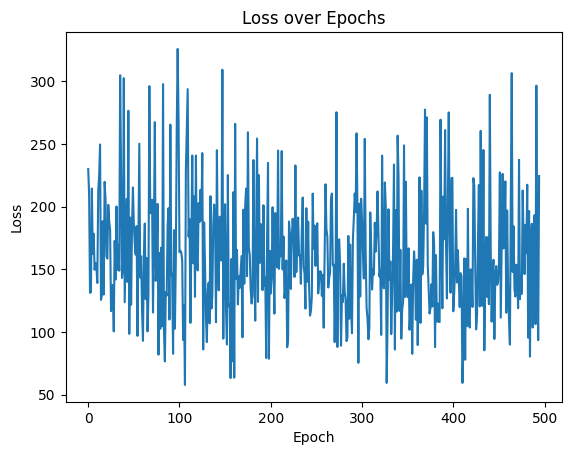

In [316]:
plt.plot(loss_list[5:])

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Plots

In [317]:
pred = model(X_test)
pred = pd.DataFrame(pred.detach().numpy())

actual = pd.DataFrame(y_test.detach().numpy())

In [318]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(index):
    actual_np = actual.values[index]
    pred_np = pred.values[index]


    plt.plot(actual.columns, actual_np, label='actual')
    plt.plot(actual.columns, pred_np, 'r+', label='predicted')

    if 0:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

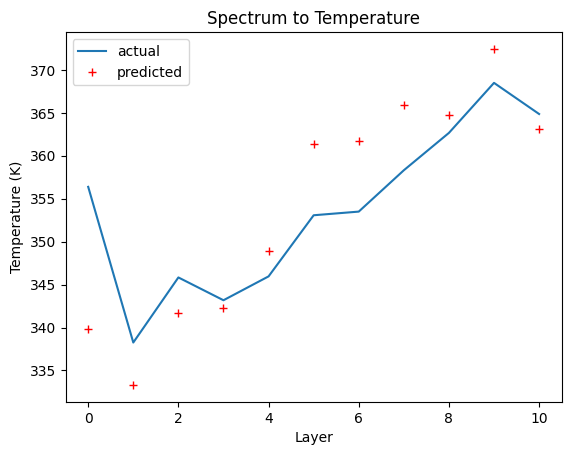

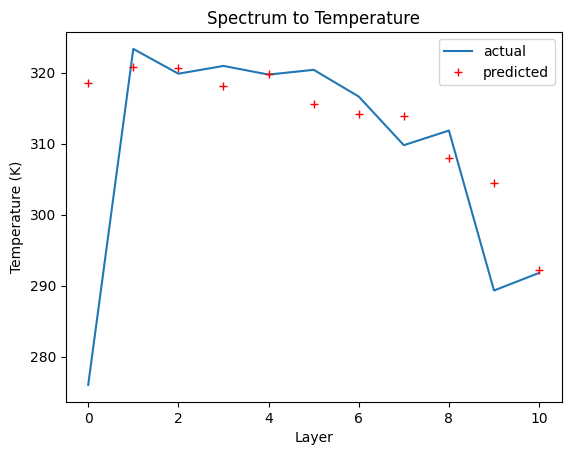

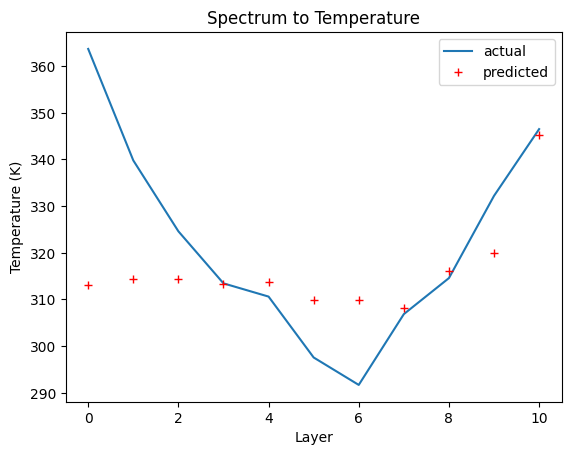

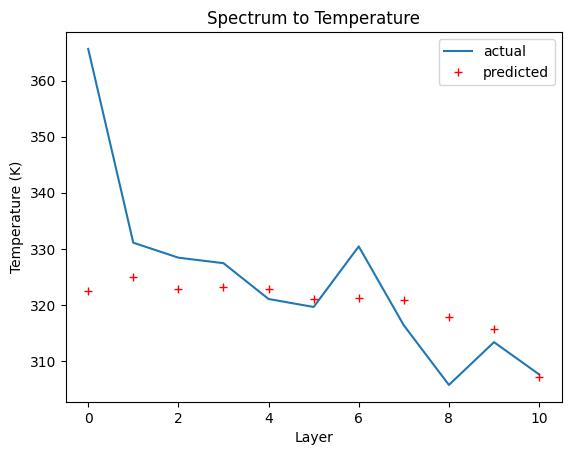

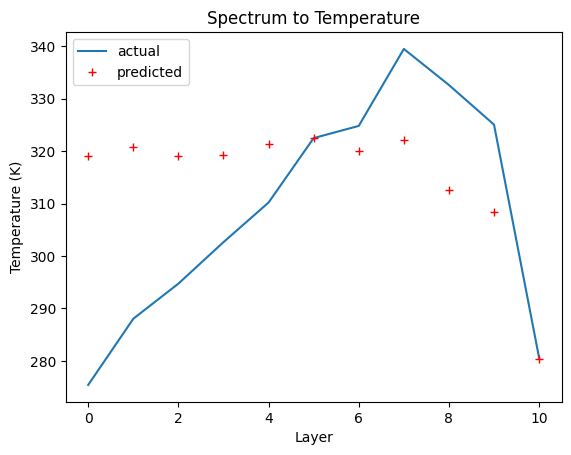

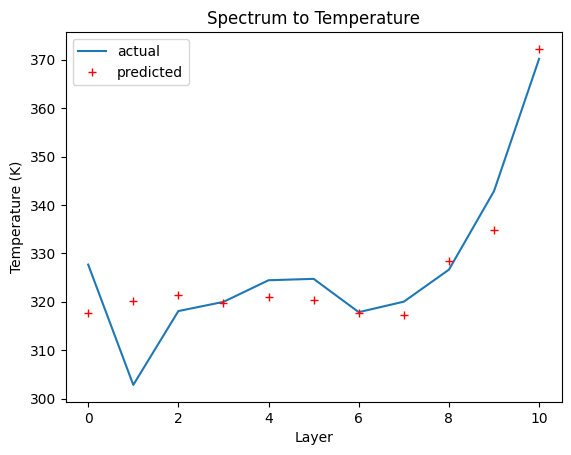

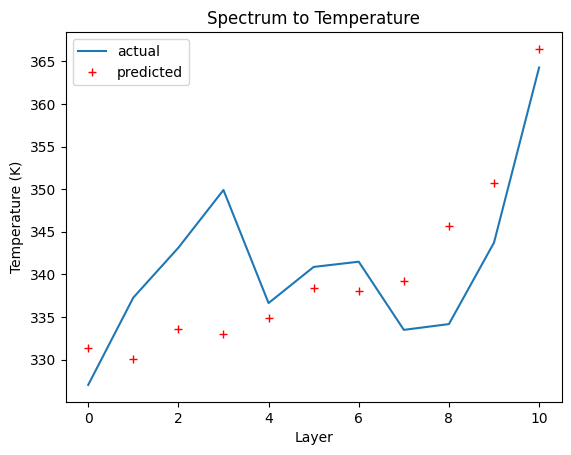

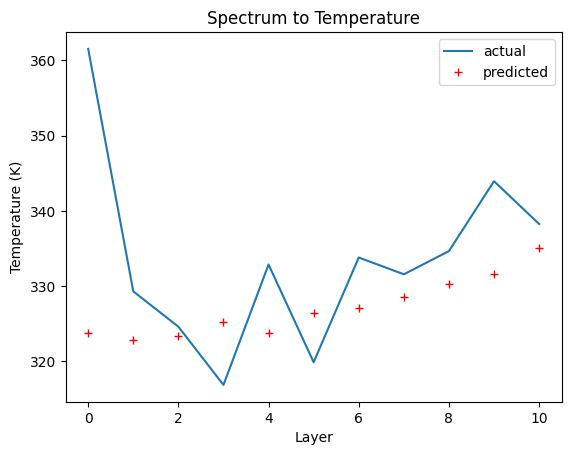

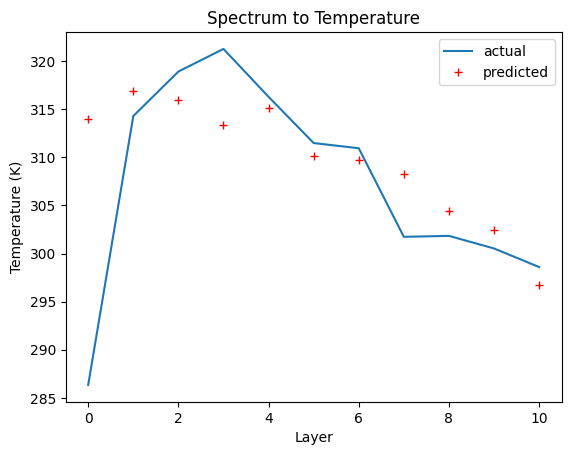

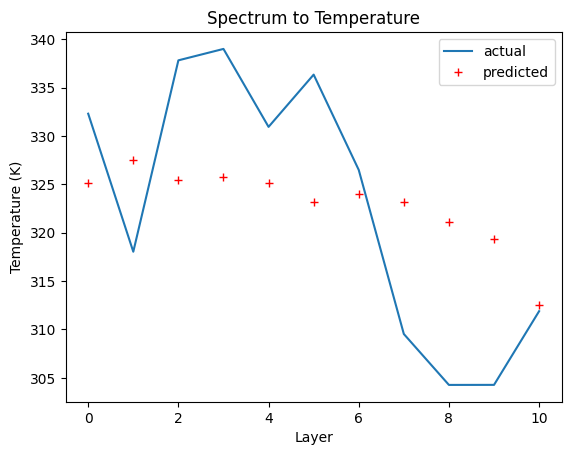

In [319]:
for index in range(10):
    plot_actual_vs_pred(index*10)